-----
-----

# LST1 PULSAR ANALYSIS WITH PULSARPHASOGRAM 
------
------


In [8]:
from PulsarPhaseogram import *
from lstchain.io.io import dl2_params_lstcam_key,dl2_params_src_dep_lstcam_key
from astropy.io import fits
import pandas as pd
import matplotlib.pylab as plt
from IPython.display import Image
import numpy as np

# 0. Overall view of the package

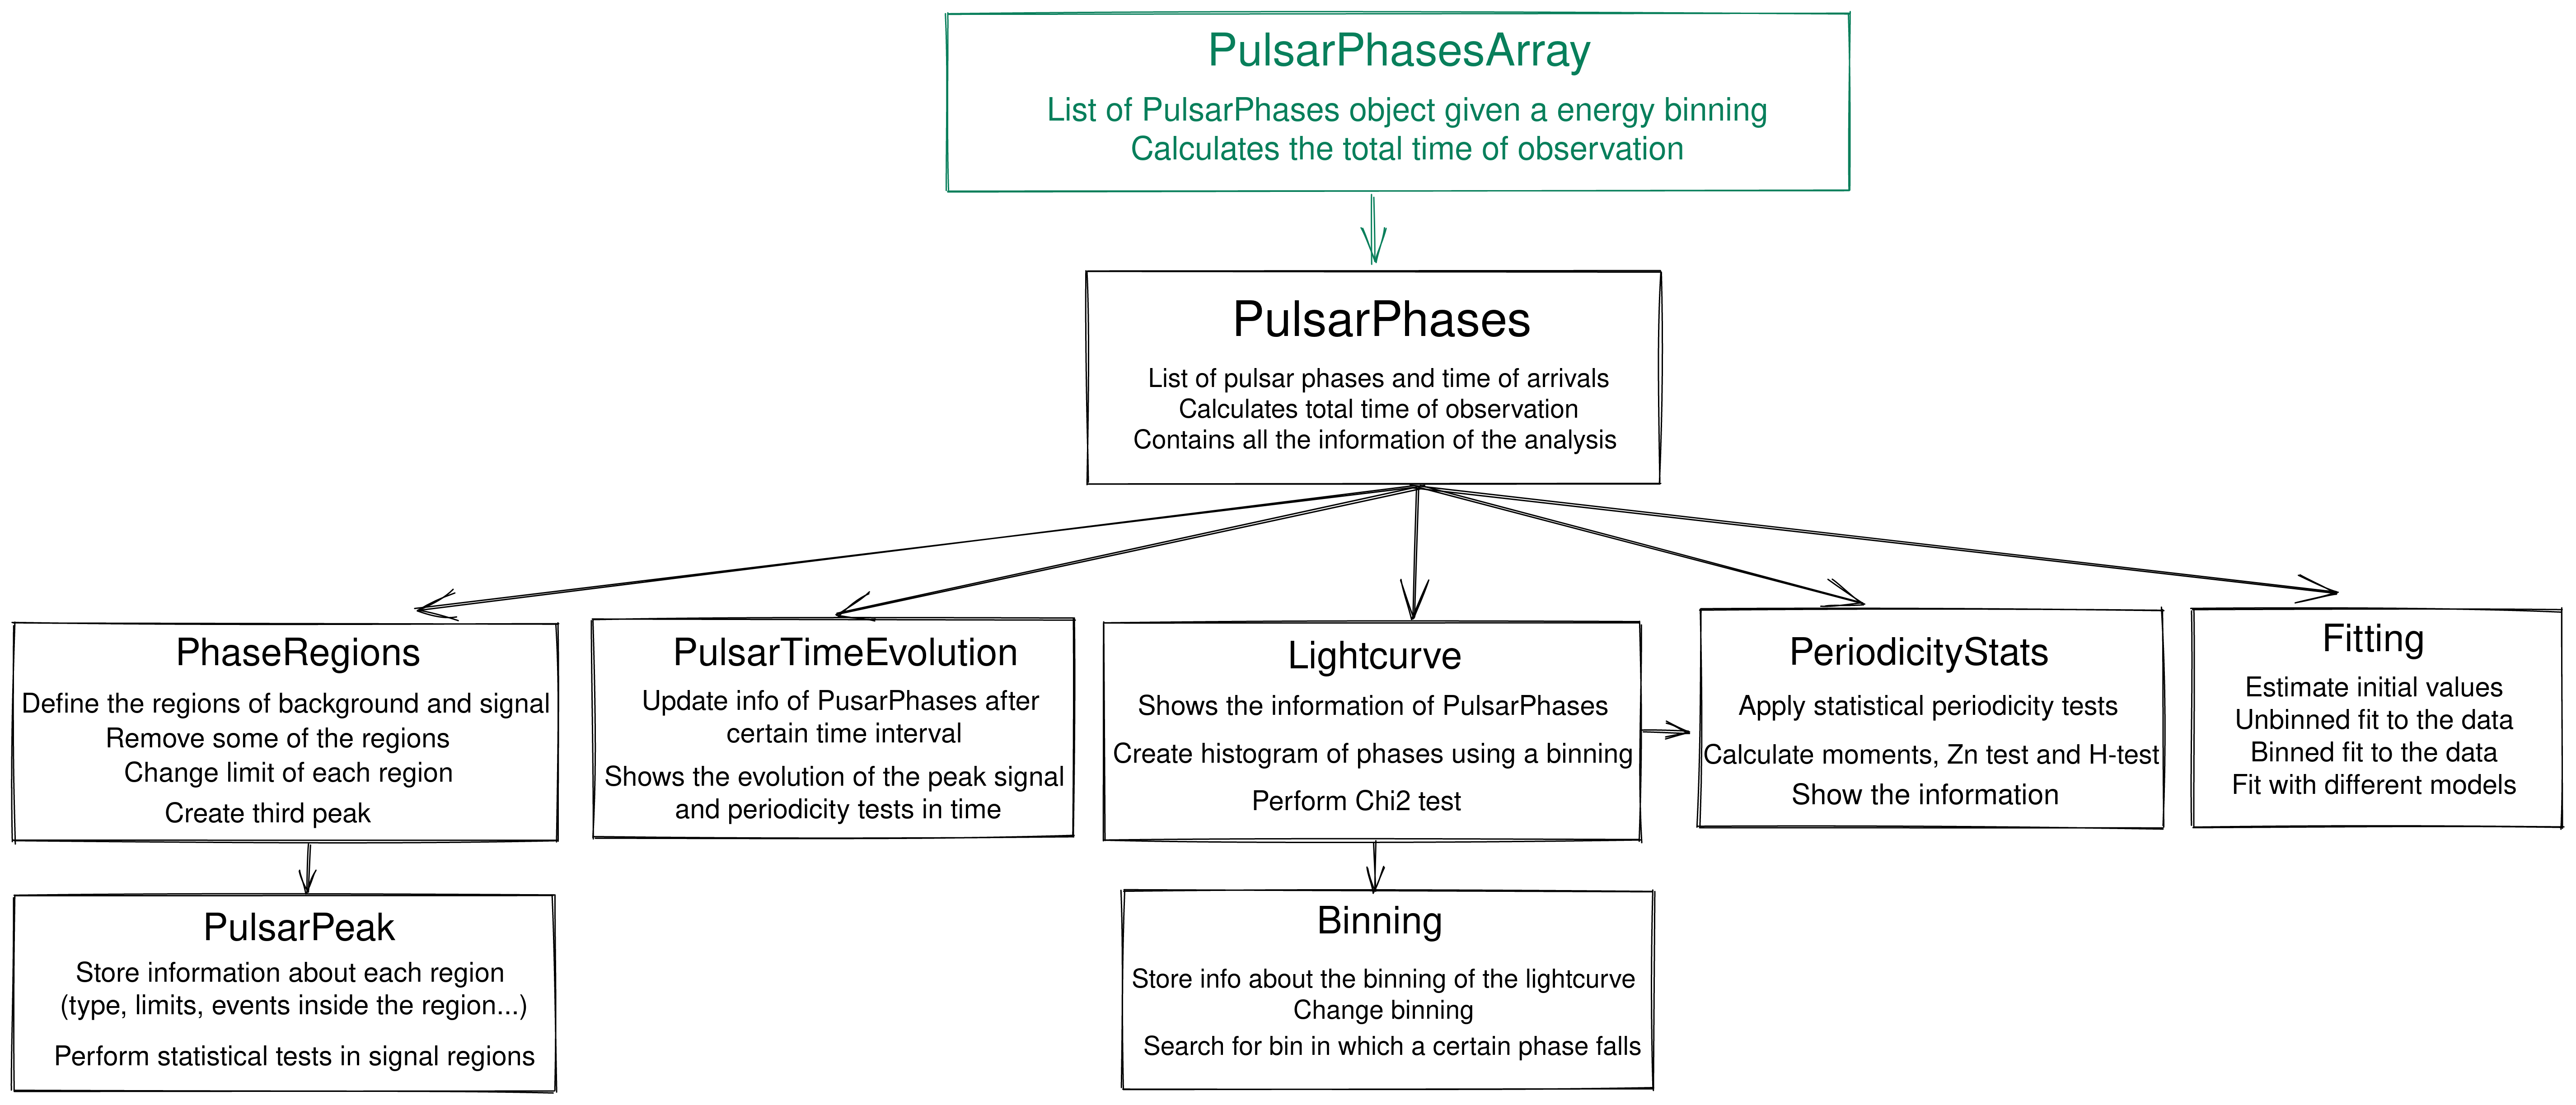

In [2]:
Image(filename='./../PPhaseogram_scheme.png')

# 1. Input data

The pulsar analysis can be performed using a dataframe that contains the main information of the events: pulsar phase, energy, time of arrival (mjd time). 

- For the LST1, DL2-files format can be used in the analysis. DL3 files could also be used but the applied cuts could not be optimal for the analysis of the pulsar.
    
    
- For Fermi-LAT data, FITS files could be used.
    
    
- If we dont use a dataframe, or the format is different from the above, we could use a list of phases, times and energies as an input.
    

## 1.1 LST1 DL2 files

Let's read a DL2 file of the LST. We will use as an example, the merged DL2 file from 20/11/2020

In [2]:
DL2_df=pd.read_hdf('/home/alvaro.mas/Pulsar_analysis/example_files/dl2_LST-1.11_2020_pulsar.h5',key=dl2_params_lstcam_key,float_precision=20)

We can show the content of the DL2 dataframe:

The necessary columns in our case are 'pulsar_phase','mjd_time' and 'reco_energy'. The pulsar phases are the rotational phase of the pulsar associated with the event, from -0.5 to 0.5. 

In [4]:
DL2_df['pulsar_phase']

98    -0.226949
120    0.011647
229    0.300167
230    0.308160
237    0.393574
         ...   
137   -0.234982
143   -0.180387
163    0.055582
169    0.088985
210    0.499882
Name: pulsar_phase, Length: 3004681, dtype: float128

The reconstructed energy is the experimental energy of the particle in TeV 

In [5]:
DL2_df['reco_energy']

98     0.029432
120    0.056884
229    0.044632
230    0.115038
237    0.055435
         ...   
137    0.032322
143    0.020729
163    0.038411
169    0.042734
210    0.079252
Name: reco_energy, Length: 3004681, dtype: float64

## 1.2 Fermi-LAT FITS file

Let's now read a Fermi-LAT FITS file.

In [6]:
hdul = fits.open('/home/alvaro.mas/Pulsar_analysis/example_files/merged2_pulsar.fits')

The columns of the table are the following:

In [7]:
print(hdul[1].columns)

ColDefs(
    name = 'ENERGY'; format = 'E'; unit = 'MeV'
    name = 'RA'; format = 'E'; unit = 'deg'
    name = 'DEC'; format = 'E'; unit = 'deg'
    name = 'L'; format = 'E'; unit = 'deg'
    name = 'B'; format = 'E'; unit = 'deg'
    name = 'THETA'; format = 'E'; unit = 'deg'
    name = 'PHI'; format = 'E'; unit = 'deg'
    name = 'ZENITH_ANGLE'; format = 'E'; unit = 'deg'
    name = 'EARTH_AZIMUTH_ANGLE'; format = 'E'; unit = 'deg'
    name = 'TIME'; format = 'D'; unit = 's'
    name = 'EVENT_ID'; format = 'J'
    name = 'RUN_ID'; format = 'J'
    name = 'RECON_VERSION'; format = 'I'
    name = 'CALIB_VERSION'; format = '3I'
    name = 'EVENT_CLASS'; format = '32X'
    name = 'EVENT_TYPE'; format = '32X'
    name = 'CONVERSION_TYPE'; format = 'I'
    name = 'LIVETIME'; format = 'D'; unit = 's'
    name = 'DIFRSP0'; format = 'E'
    name = 'DIFRSP1'; format = 'E'
    name = 'DIFRSP2'; format = 'E'
    name = 'DIFRSP3'; format = 'E'
    name = 'DIFRSP4'; format = 'E'
    name = 'MJD_B

In [8]:
hdul[1].data['MJD_BARYCENT_TIME']

array([59112.26026998, 59112.26189534, 59112.26288303, ...,
       59477.20894081, 59477.21018794, 59477.21034653])

And the data rows can be shown as following:

We can see that there are three columnn called PULSE_PHASE, ENERGY and TIME that are the one that will be used for the analysis.

# 2. PulsarPhases class

## 2.1 Creating the PulsarPhases object from dataframe

The main object of the analysis is the PulsarPhases object. This class allows to store all the main information of the phases and times. Let's create it. We should give as inputs:
    
- The dataframe mentioned before (__dataframe__)


- The phase interval of the two peaks (__peak_limits_1 and peak_limits_2__) and the phase interval of the background region in the lightcurve (__off_limits__)


- The number of bins used in the lightcurve (__nbins__)
        Default:50
    
    
- A boolean input called __binned__. If True, a binned fit is applied, otherwise an unbinned fit is used.
        Default:True
        
        
- Telescope name (optional): LST1 or Fermi-LAT (Default LST1)

In [8]:
h=PulsarPhases(dataframe=DL2_df,nbins=50,peak_limits_1=[0.983,0.026],peak_limits_2=[0.377,0.422],off_limits=[0.52,0.87],binned=True,tinterval=3600)

/home/alvaro.mas/miniconda3/envs/lst-dev/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


The FermiPulsarPhases is the analog of Pulsarhases for Fermi-LAT data inputs. It has the same attributes as PulsarPhases class.

In [3]:
h=FermiPulsarPhases(fits_table=hdul[1].data[0:500],nbins=50,peak_limits_1=[0.983,0.026],peak_limits_2=[0.377,0.422],off_limits=[0.52,0.87],binned=True,tinterval=3600*24)

## 2.2 Creating the object from lists

If we do not have a dataframe, a list with the phases and times could be provided to generate the object (set dataframe parameter to None). 

- A __list of phases__ (pdata)

    
- A __list of times__ (ptimes)


- A total time of observation: __tobservation__. If no tobservation is provided it is estimated using the list of times.

    
- The phase interval of the two peaks (__peak_limits_1 and peak_limits_2__) and the phase interval of the background region in the lightcurve (__off_limits__)

    
- The number of bins used in the lightcurve (__nbins__)
        Default:50
        
    
- A boolean input called __binned__. If True, a binned fit is applied, otherwise an unbinned fit is used.
        Default:True
        
        
        
- Telescope name (optional): LST1 or Fermi-LAT (Default LST1)


In [26]:
h_list=PulsarPhases(dataframe=None,pdata=DL2_df['pulsar_phase'].to_list(),ptimes=DL2_df['dragon_time'].to_list(),nbins=50,peak_limits_1=[0.983,0.026],peak_limits_2=[0.377,0.422],off_limits=[0.52,0.87],binned=True,tinterval=3600)

No mjd_times found in the dataframe


/home/alvaro.mas/miniconda3/envs/lst-dev/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


## 2.3 Accesing to the information

This object have different attributes storing the information of the dataframe:

In [9]:
print(h.phases)
print(h.times)

[0.77305071 0.01164685 0.30016736 ... 0.05558205 0.08898496 0.49988166]
[1.60574112e+09 1.60574112e+09 1.60574112e+09 ... 1.60611194e+09
 1.60611194e+09 1.60611194e+09]


It also calculates the total time of observation in hours:

In [10]:
print(h.tobs)

12.731559984750218


The rest of the attributes contain the information of all the pulsar analysis using Subclasses. A list of this attributes is the following (created in that order):

1. A __PhaseRegion__ object created with the phase intervals given for the bkg/signal regions. This object contains the information of the different regions and its statistics using another class called __PulsarPeak__
    
    
2. A __LightCurve__ object containing the information of the binning (using class __PhaseBinning__) and the histogram of the phases (the phaseogram). This class is also used later for showing the results of the analysis.
    
    
3. A __PeriodicityTest__ object that applies the periodicity tests using the list of phases and the lightcurve previously constructed and stored in the LightCurve object.
    
    
4. A __PeakFitting__ object storing the information of the lightcurve fitting to a model. This fitting could be done using the lightcurve (binned fitting) or using the list of phases from the main object (unbinned likelihood fitting). By default, the binned fitting is applied.

We can access fast to all the information of the SubClasses (all the pulsar analysis) using the following command:

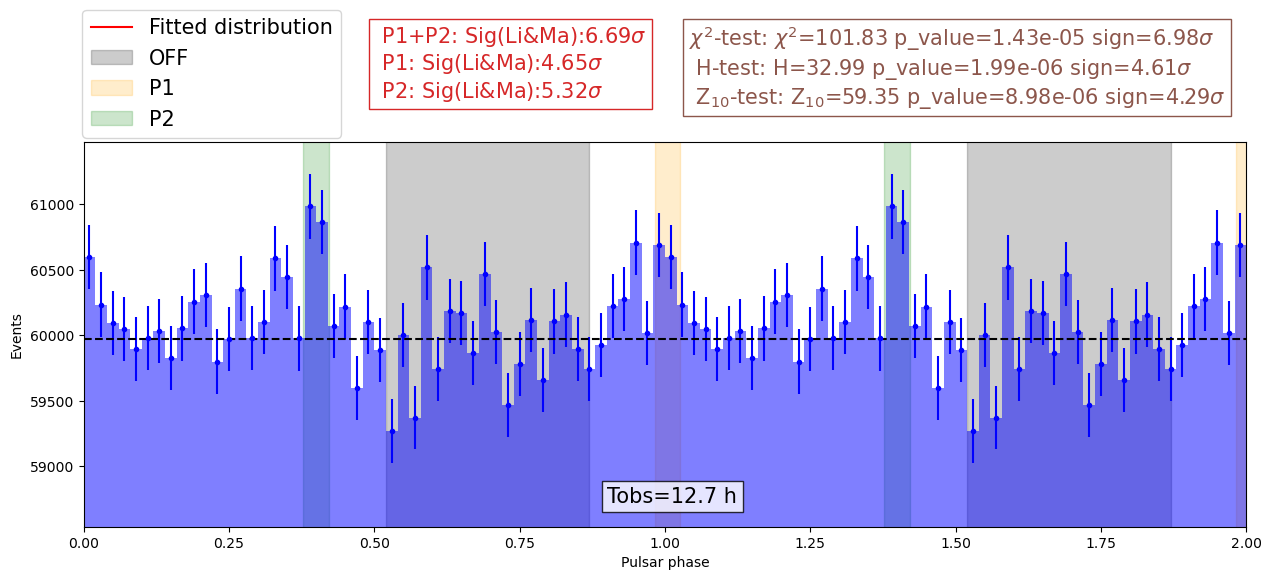

In [11]:
h.histogram.show_phaseogram(h,phase_limits=[0,2])

We will later explain in detail the above function

# 3. PulsarTimeEvolution class

This class allows to store and represent the time evolution of the signal. The PulsarPhases object is updated every _tint_ seconds (by default an hour of observation), storing in the attributes of this class the values of the significance and excess events. The final PulsarPhases object is the last time it is updated (equivalent to the total time of observation).

----

- The PulsarPhases object that will be updated every __tint__ seconds


- The phase interval of the two peaks (__peak_limits_1 and peak_limits_2__) and the phase interval of the background region in the lightcurve (__off_limits__)

    
- The number of bins used in the lightcurve (__nbins__)
        Default:50
        
- The time interval to update the information or time difference between points (__tint__)
        Default:3600s

We can cretae manually a PulsarTimeEvolution object:

In [13]:
PTime=PulsarTimeEvolution(h,nbins=50,peak_limits_1=[0.983,0.026],peak_limits_2=[0.377,0.422],off_limits=[0.52,0.87],tint=3600)

## 3.1 Representing the evolution of the signal in time

The PulsarTimeEvolution object is calculated automatically when calling to the PulsarPhases class. It is created as an attribute called TimeEv. We can plot the significance in each peak and the significance of each statistical test as a function of the accumulated time of observation. For that we simply right:

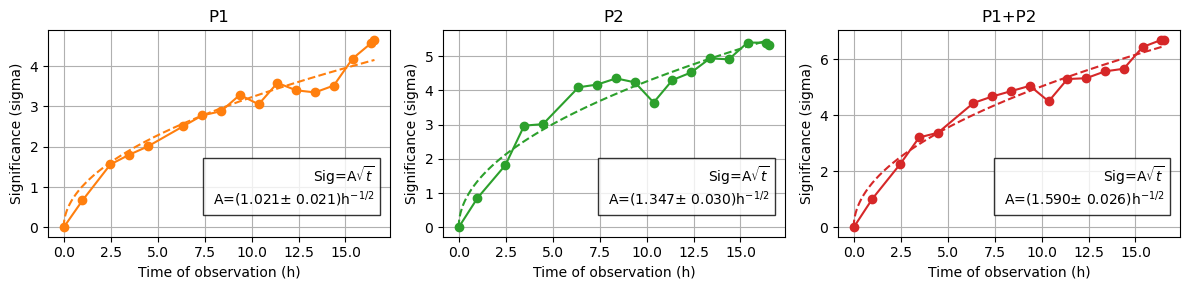

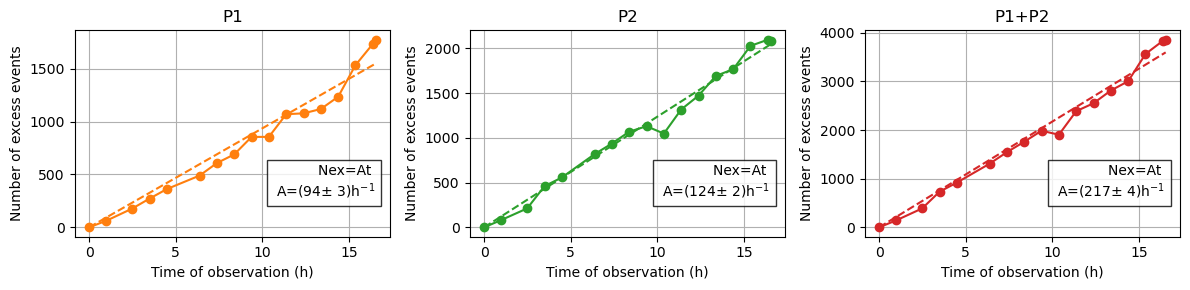

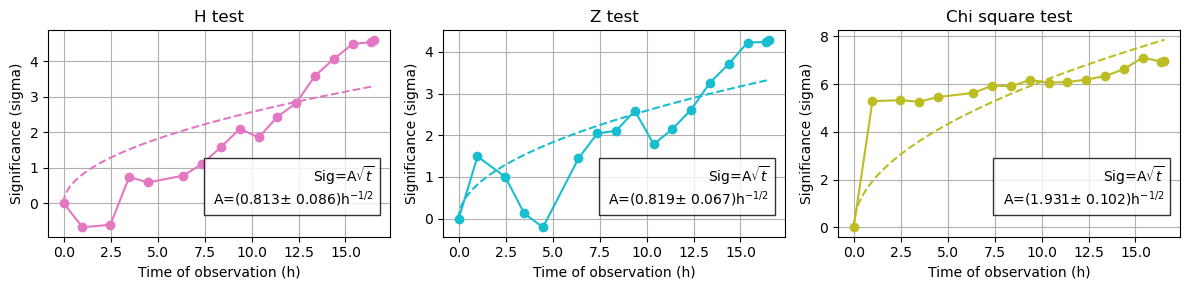

In [12]:
h.TimeEv.show_results()

We can see the evolution. It has been fitted to its expected behaviour (square root of the time for the Li&Ma significance and linear for the excess events).

And we can compare the signal of both peak:

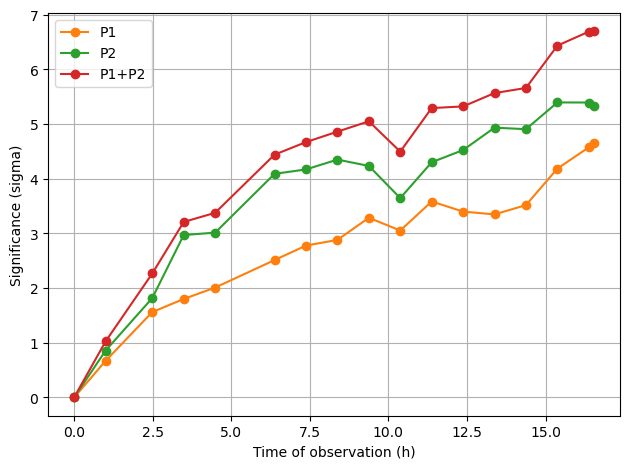

In [13]:
h.TimeEv.compare_Peaksig()

# 4. PhaseRegion class

This class allows to define the different regions in the lightcurve. We can define the phase interval of the different peaks of the pulsar, the background, the bridge, etc. We need at least one background and signal region to do the statistics.

The different inputs of this class are:

- A __PulsarPhases__ object containing the list of phases
    
    
- The phase interval of the two peaks (__peak_limits_1 and peak_limits_2__) and the phase interval of the background region in the lightcurve (__off_limits__)
    
It can be created with the following command. 

In [14]:
r=PhaseRegions(h,off_limits=[-0.48,0.87-1], peak_limits_1=[0.983-1,0.026],peak_limits_2=[0.377,0.422])

/fefs/home/alvaro.mas/Pulsar_analysis/Notebooks/PulsarPhaseogram/Pulsarpeak.py:104: RuntimeWarning: divide by zero encountered in double_scalars
  self.s_n_ratio=self.Nex/np.sqrt(noff)


In [15]:
print(r)

## 4.1. PhaseRegion object in the pulsar analysis

When we create a PulsarPhase object, the PhaseRegion object is also calculated automatically and stored in the sel.regions attribute. In principle, we don't need to manually create it unless we want to define it externally.

Let's analyze the PhaseRegion information. 

In [16]:
Regions=h.regions

In [17]:
print(Regions)

The main attributes of this class are the regions (P1, P2,P1+P2 and OFF). This attributes are calculated as PulsarPeak objects.

In [18]:
Regions.npeaks

2

In [19]:
Regions.P1

In [20]:
Regions.P2

In [21]:
Regions.P1P2

In [22]:
Regions.OFF

### 4.1.1 PulsarPeak object

This PulsarPeak class contain the information of the region (type of region, limits, size of the interval, number of regions,etc). Inputs:

- __PulsarPhases__ object with the list of phases


- __PhaseRegions__ object with the information of the regions (especially OFF region for statistics)


- __Peak_limits__ with the limits of that region


- __Peaktype__: signal/background

It can be created using the following command:

In [23]:
p=PulsarPeak(h,h.regions,[0,0.1],peaktype='signal')

Again, this does not need to be done manually since it is done when creating the PulsarPhases object. This has only to be done manually when creating regions that are not initially defined (for example more than 3 peaks in the lightcurve).

### 4.1.2 Accessing to information of the regions

In [24]:
P1=Regions.P1

In [25]:
OFF=Regions.OFF

We can see the type of the region:

In [26]:
P1.type

'signal'

In [27]:
OFF.type

'background'

We can see the information fo the region

In [28]:
P1.limits

[0.983, 0.026]

In [29]:
P1.deltaP

0.04300000000000001

In [30]:
P1.nregions

1.0

It also filters the data belonging to the phase interval.

In [31]:
P1.phases

array([0.01164685, 0.98373758, 0.98604643, ..., 0.00582177, 0.98705416,
       0.00167682], dtype=float128)

And the number of events in the region

In [32]:
P1.number

130607

In the case of a signal region we can extract the information of the statistics (significance in sigmas, number of excess events, associated error, signal/sqrt(tobs), s/n ratio):

In [33]:
P1.sign

4.653595044651049

In [34]:
P1.Nex

1774.454285714237

In [35]:
P1.yerr

382.66826164900243

In [36]:
P1.sign_ratio

1.3042107574493826

In [37]:
P1.s_n_ratio

4.943699005539705

We can also define PulsarPeak objects with more than one number of intervals. For example:

In [38]:
P1P2=Regions.P1P2

In [39]:
P1P2.type

'signal'

In [40]:
P1P2.limits

[0.983, 0.026, 0.377, 0.422]

In [41]:
P1P2.nregions

2.0

## 4.2. PhaseRegions methods

The PhaseRegions class allows to do some changes in the lightcurve regions and show the information of the statistics:

We can show the significance of the excess events in each region:

In [42]:
h.regions.show_peak_results()

{'P1+P2': 6.694635488039387, 'P1': 4.653595044651049, 'P2': 5.322833841771875}

### 4.2.1 Changing limits 

We can change the limits of one region:

In [43]:
h.regions.change_limits(h,new_off_limits=[0.10,0.30])

In [44]:
h.regions.OFF.limits

[0.1, 0.3]

In [45]:
h.regions.OFF.deltaP

0.19999999999999998

The new statistics are automatically applied when changing limits of one region:

In [46]:
h.regions.show_peak_results()

{'P1+P2': 5.275843306054603, 'P1': 3.7393881455524642, 'P2': 4.36064430655251}

### 4.2.2 Adding third peak

We can add a third peak (for example, the bridge region of the Crab lightcurve).

In [47]:
h.regions.change_limits(h,new_off_limits=[0.52,0.87])
h.regions.third_peak(h,[0.04,0.32])

In [48]:
h.regions.P3.type

'signal'

In [49]:
h.regions.P3.limits

[0.04, 0.32]

In [50]:
h.regions.P3.sign

1.4619315942032858

And it also creates a signal object with the sum of all the signal regions

In [51]:
h.regions.P1P2P3.type

'signal'

In [52]:
h.regions.P1P2P3.limits

[0.983, 0.026, 0.377, 0.422, 0.04, 0.32]

In [53]:
h.regions.P1P2P3.sign

3.754673001264946

In [54]:
h.regions.show_peak_results()

{'P1+P2': 6.694635488039387,
 'P1': 4.653595044651049,
 'P2': 5.322833841771875,
 'P3': 1.4619315942032858,
 'P1+P2+P3': 3.754673001264946}

### 4.2.3 Removing peaks

We can also remove one region. Let's remove the bridge region (region number 3):

In [55]:
h.regions.remove_peak('P3')

In [56]:
print(h.regions.P3)

None


In [57]:
h.regions.npeaks

2

In [58]:
h.regions.show_peak_results()

{'P1+P2': 6.694635488039387, 'P1': 4.653595044651049, 'P2': 5.322833841771875}

# 5. LightCurve class

The LightCurve class allows to make the histogram of the pulsar phases and store it. It first creates the binning using the SubClass PhaseBinning and then creats the histogram. The inputs of this class are:

- A __PulsarPhases__ object with the pulsar phases list
    
    
- The number of bins (__nbins__). 
        Default:50

We can create manually this object by writing:

In [59]:
lc=Lightcurve(h,nbins=50)

In [60]:
print(lc)

## 5.1. Accessing to the information of LightCurve object

When the PulsarPhases object is created, the LightCurve is also created as an attribute called histogram.

In [61]:
phaseogram=h.histogram

In [62]:
print(phaseogram)

The binning is created using the Subclass PhaseBinning, that will be explained below

In [63]:
binning=phaseogram.binning

In [64]:
print(binning)

We can extract the information of the histogram, the height of the bins and the edges

In [65]:
height=phaseogram.lc[0]
bin_edges=phaseogram.lc[1]

In [66]:
print(height)

[60598 60235 60096 60047 59895 59982 60032 59829 60052 60258 60307 59800
 59975 60356 59979 60099 60588 60447 59976 60984 60866 60072 60219 59601
 60104 59891 59269 60003 59372 60518 59741 60187 60172 59866 60467 60027
 59465 59783 60117 59659 60106 60158 59895 59741 59929 60223 60278 60707
 60020 60690]


In [67]:
print(bin_edges)

[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]


## 5.2. Representing the lightcurve

We can represent the lightcurve with the following command. 

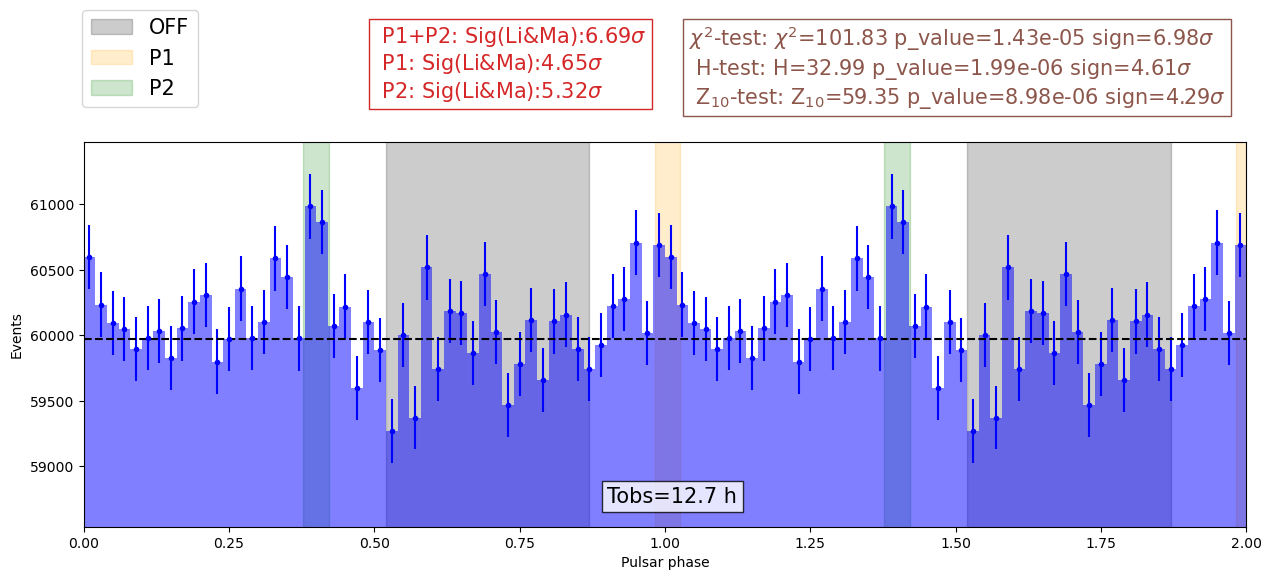

In [68]:
h.histogram.show_phaseogram(h,phase_limits=[0,2],fit=False,colorhist='blue')

We can chose the peaks we want to show. By default, both are shown, but we can show only one by setting signal='P1' or signal='P2'. We can also change the color of the peaks or background.

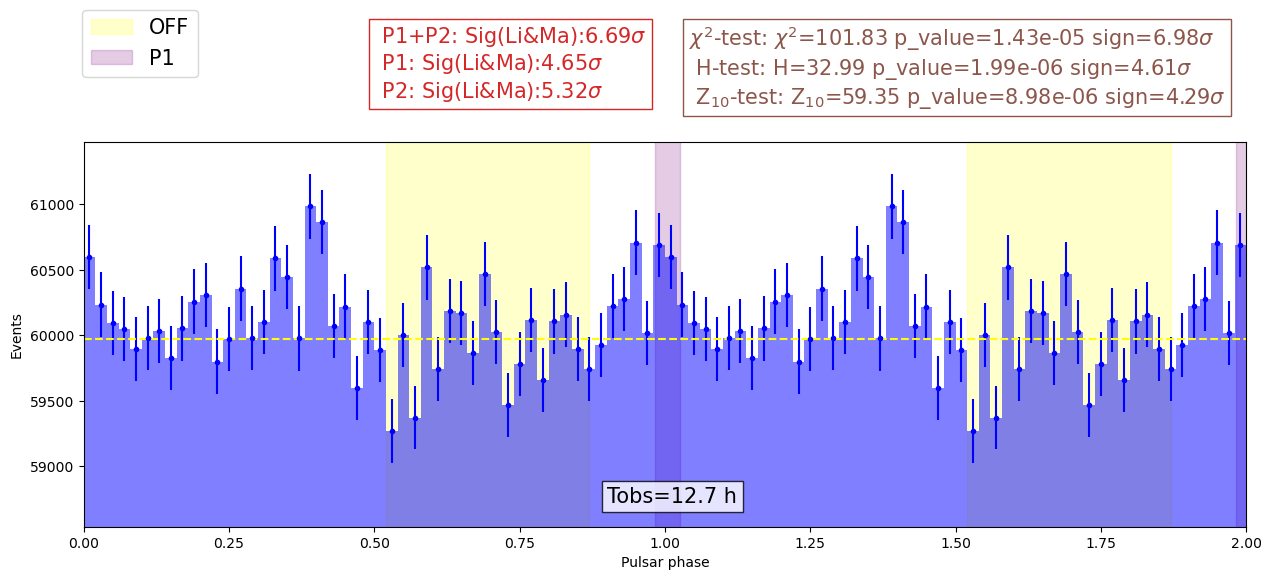

In [69]:
h.histogram.show_phaseogram(h,phase_limits=[0,2],fit=False,signal='P1',colorP1='purple',colorb='yellow')

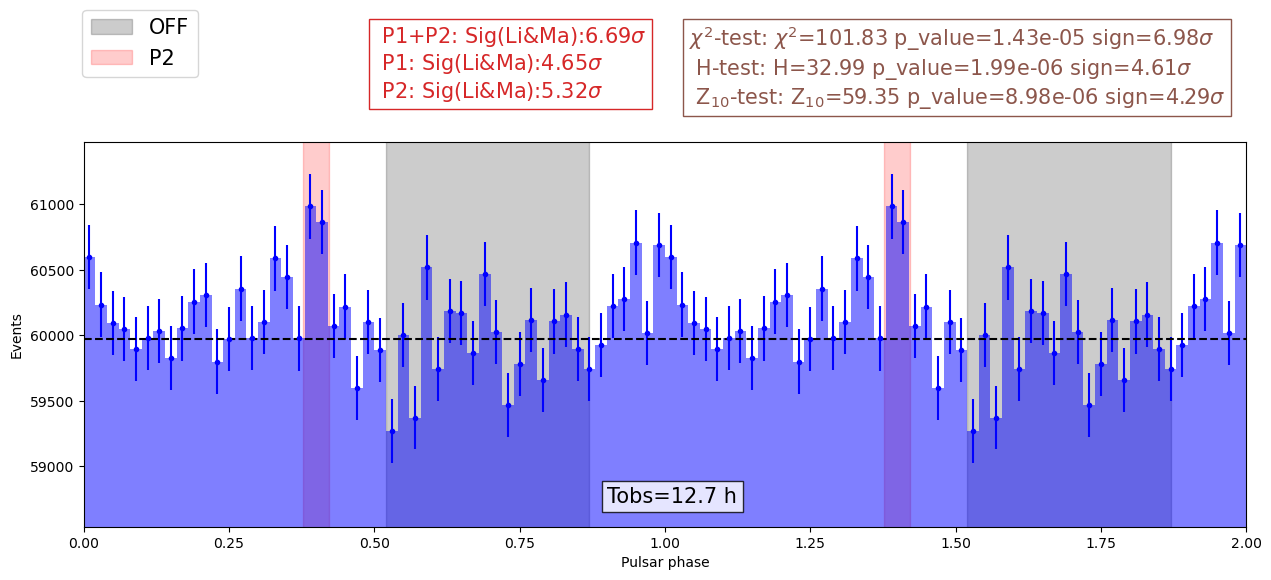

In [70]:
h.histogram.show_phaseogram(h,phase_limits=[0,2],fit=False,signal='P2',colorP2='red')

We can remove the horizontal line that shows the background level

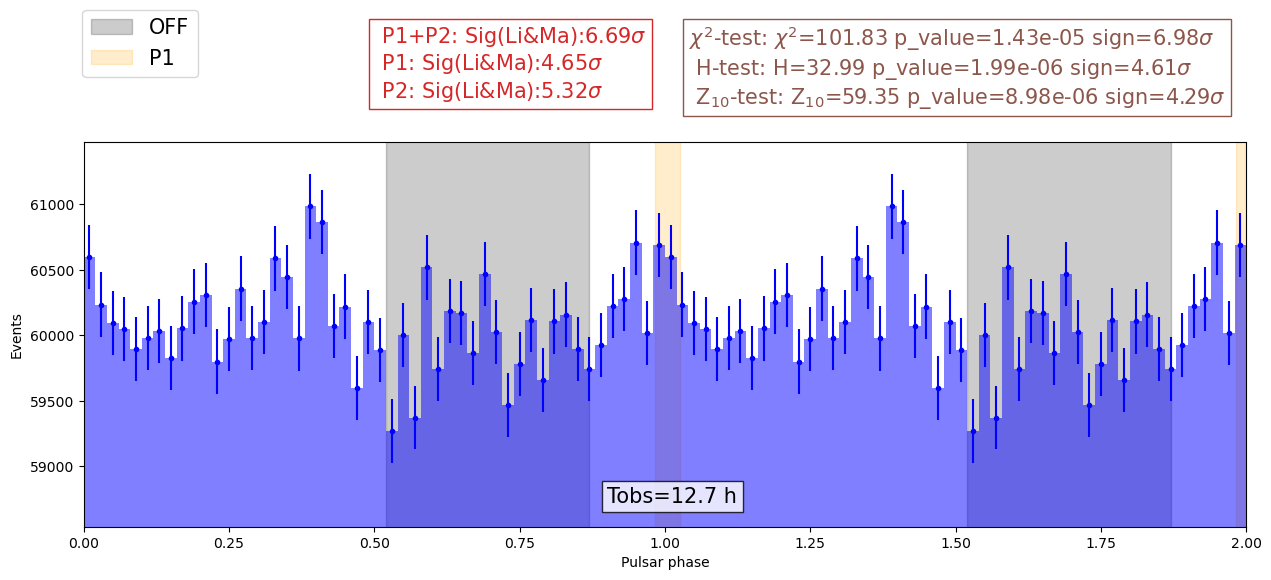

In [71]:
h.histogram.show_phaseogram(h,phase_limits=[0,2],fit=False,signal='P1',hline=False)

We can remove the background marker

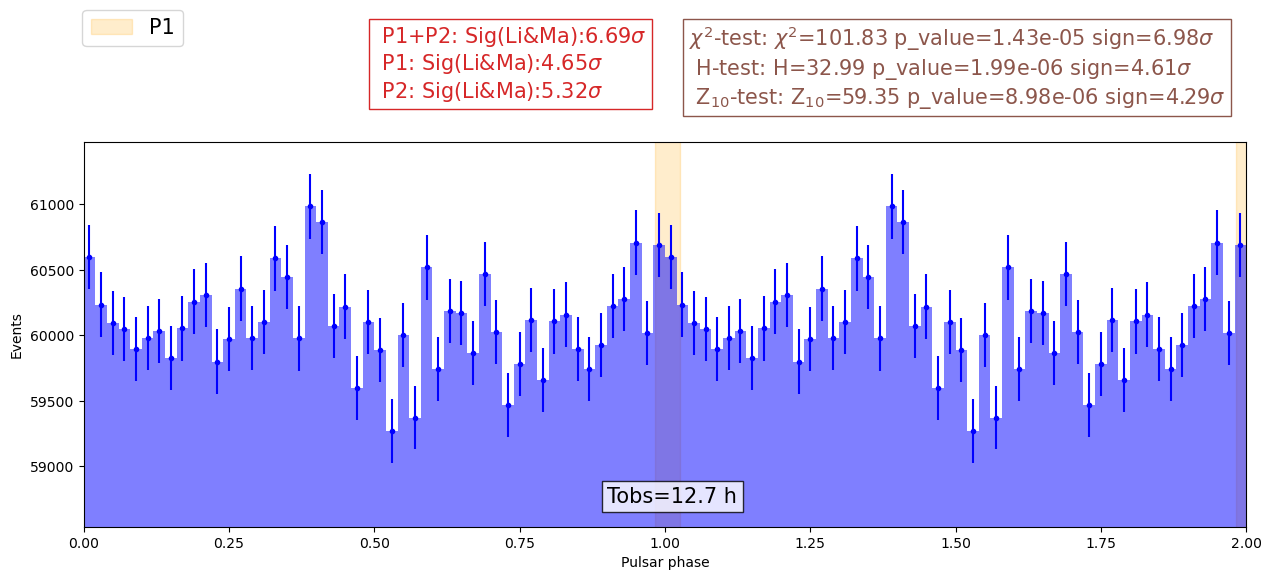

In [72]:
h.histogram.show_phaseogram(h,phase_limits=[0,2],fit=False,signal='P1',background=False)

We can also decide not to show some labels with the results of the statistics

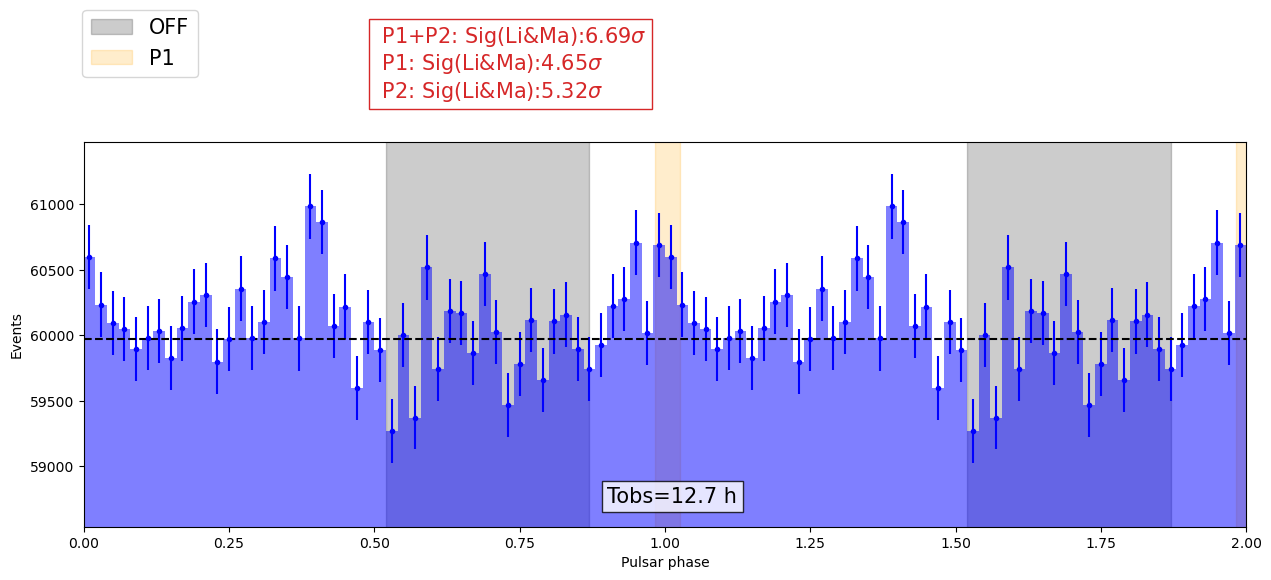

In [73]:
h.histogram.show_phaseogram(h,phase_limits=[0,2],fit=False,signal='P1',periodstats=False)

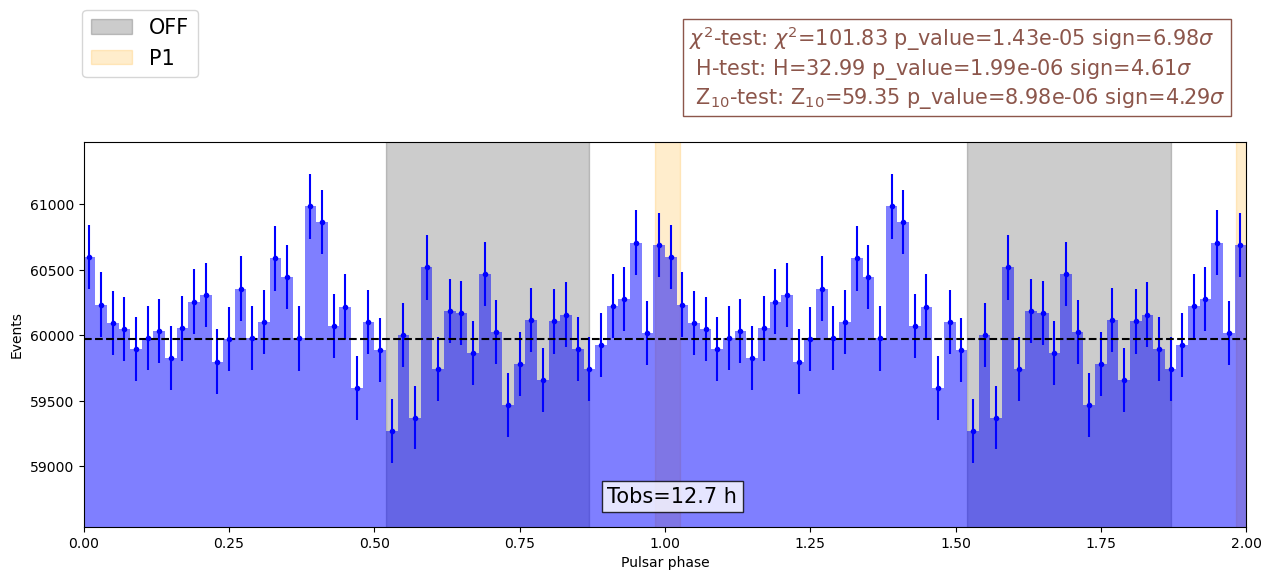

In [74]:
h.histogram.show_phaseogram(h,phase_limits=[0,2],fit=False,signal='P1',peakstats=False)

And finally, we can change the limit of the histogram with the parameter phase_limits. 

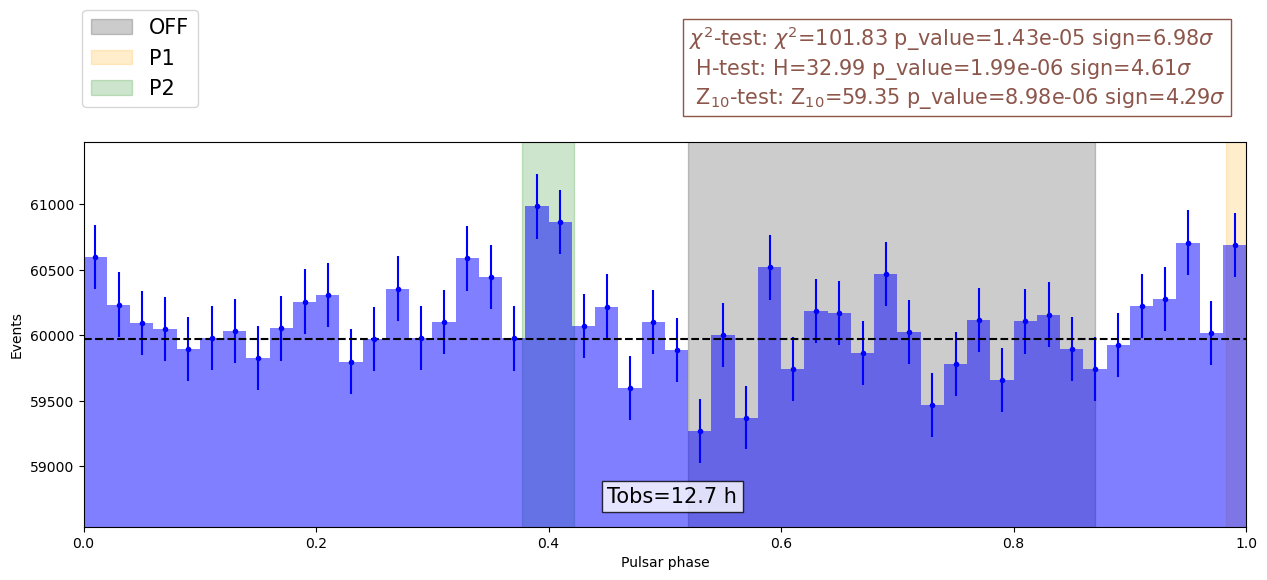

In [75]:
h.histogram.show_phaseogram(h,phase_limits=[0,1],fit=False,signal='both',peakstats=False)

## 5.3 PhaseBinning class

The PhaseBinning class controls the binning of the lightcurve. It stores the information of the binning and allos to change i. The inputs of this class are:

- Number of bins (__nbins__)
        Default:50
        
        
- __xmin,xmax__ values of the binning
    
We can create the object manually writing:

In [76]:
bn=PhaseBinning(50,xmin=-0.5,xmax=0.5)

When the lightcurve is built in the LightCurve Class, the binning is also created automatically using the number of bins given as an input in the PulsarPhase call (default 50)

### 5.3.1 Looking into the information about the binning

We can examine the attributes of the class:

Number of bins

In [77]:
binning.nbins

50

Maximum and minimum value of the binning (only for 1 period)

In [78]:
print(binning.xmin)
print(binning.xmax)

0
1


Edges of all the bins

In [79]:
binning.edges

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ])

### 5.3.2 Changing the binning

We can change the binning using the following method:

In [80]:
h.histogram.binning.set_edges(nbins=30,xmin=0,xmax=1)

Here we have changed the binning to have 30 bins in 1 period. The next step is to create again the histogram:

In [81]:
h.histogram.create_histogram(h)

And show again

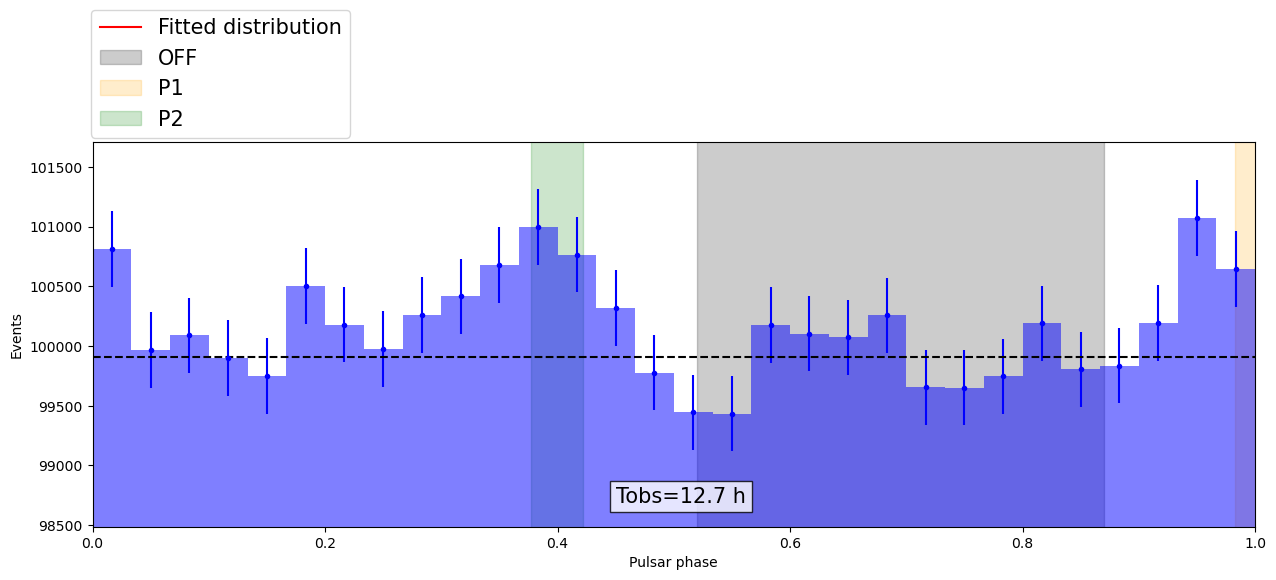

In [82]:
h.histogram.show_phaseogram(h,periodstats=False,peakstats=False)

The statistical tests depending on the binning need to be also redone (see next point).

### 5.3.3 Other method os the PhaseBinning class

This class allows also to calculate the bin in which a particular phase falls:

In [83]:
binning.Find_LowHiEdge(0.3)

(8, 9)

And we can also calculate which is the nearest one between them:

In [84]:
binning.Find_CloseEdge(0.3)

9

# 6. PeriodicityTest class

This class calculates and stores the results of the periodicity search. 3 tests are applied: Chi-square, Zn-test and H-test. The Chi-square test is implemented as a method of the LightCurve Class but calculated when creating the PeriodicityTest object.The Zn-square is calculated by default using n=10. The inputs of this class are:

- __PulsarPhases__ object with the list of phases and already containing the LightCurve object as an attribute.

The object might be created manually writing the following line:

In [85]:
p=PeriodicityTest(h)

## 6.1 Accessing information of the class

When the PulsarPhases object is created, after creating the PhaseRegions and LightCurve objects, it also creates the PerioicityTest automatically as an attribute called 'stats'. When the class is called, it applies all the periodicity tests by default.

In [86]:
p=h.stats

We can fast check the results of the different tests:

In [87]:
p.resume_Pstats()

,Chi_square_test,Zn_test,H_test
Statistic,101.834700,59.347145,32.987526
p-value,0.000014,0.000009,0.000002
Number of $\sigma$,6.984613,4.288781,4.612769


We can also extract the information separately for each test (statistic, p-value,significance (sigmas)):

In [88]:
p.chisqr_res

(101.83470025603383, 1.4282111998634549e-05, 6.984613009018267)

In [89]:
p.Htest_res

(32.987525695804573597, 1.9867007156932527311e-06, 4.612768827132449)

In [90]:
p.Zntest_res

(59.34714505857104036, 8.982812968318859e-06, 4.288781180092388)

For the later case we can also check the order 'n' at which the Zn test is performed:

In [91]:
p.Zn_n

10

We can also access other intermedium information, such as the cosine and sine moments, used in the Zn and H-test. 

In [92]:
p.cos

array([ 1309.05953482,  1247.95113124,  5055.69567194, -1608.0756868 ,
        3894.60121081,   938.27628537,   184.59456515,  -253.00021873,
       -1061.82310039,  2965.09903825,  -106.91998475,  1598.07610856,
         349.12721139,  -283.0929785 ,  1189.33604694,  1055.54552575,
        1388.77579626,  2645.312018  , -1647.20478036,  1432.76786909,
        -495.71457764,  3240.21656329,   385.25647332,   610.86348973,
         239.81875294], dtype=float128)

In [93]:
p.sin

array([ 3039.18790199, -3139.1855276 ,   257.55249247, -2801.82998147,
         -57.50487982,  -597.87542223, -1058.64126478,  1093.01113115,
         412.63582677,   161.1871929 ,  1336.1950747 ,  1799.4693304 ,
        1338.38219722, -2561.7232833 ,   442.92561125,  4120.14508256,
       -1407.97368415,  -108.55557869,   678.71673834, -2233.40349205,
        1449.79001426, -1517.45442381, -1254.65745565, -1089.67815708,
        -399.11362366], dtype=float128)

## 6.2. Performing manually the tests

If we want to recalculate one of the tests (for example, after changing the binning or other parameters), we have to manually update it. Let's performe again the Zn-test changing the value of 'n' from 10 to 15

In [94]:
h.stats.zn_test(n=15)

(82.010540499235132686, 1.0113221063791363e-06, 4.751148595140245)

In [95]:
h.stats.resume_Pstats()

,Chi_square_test,Zn_test,H_test
Statistic,101.834700,82.010540,32.987526
p-value,0.000014,0.000001,0.000002
Number of $\sigma$,6.984613,4.751149,4.612769


In [96]:
h.stats.Zn_n

15

Imagine we change now the binning and we have to perform again the chi-sqr test (the only one depending on the binning). Therefore, we should write the following:

In [97]:
h.histogram.binning.set_edges(nbins=60)
h.histogram.create_histogram(h)

In [98]:
h.stats.chisqr_res=h.histogram.chi_sqr_pulsar_test()

In [99]:
h.stats.resume_Pstats()

,Chi_square_test,Zn_test,H_test
Statistic,113.570692,82.010540,32.987526
p-value,0.000026,0.000001,0.000002
Number of $\sigma$,6.901677,4.751149,4.612769


# 7. PeakFitting class

The last object created when we call the PulsarPhases Class is a PeakFitting object. The PeakFitting class allows to perform a fit using different models and algorithms. By default, a binned fit to the lightcurve assuming a double gaussian model for the peaks is performed. To create this object we need the following parameters:

- __PulsarPhases__ object containing the list of events and the previously constructed lightcurve
    
    
- __Model__ used in the analysis (by default model='dgaussian')
    
    
- Boolean variable called __binned__. If True a binned fit is performed, otherwise an unbinned likelihood fit is done.
    
Manually it can be created as follows:

In [101]:
f=PeakFitting(h,model='dgaussian',binned=True)

/home/alvaro.mas/miniconda3/envs/lst-dev/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


This last line will define the model, the initial values for the parameters and perform a Binned likelihood. This is the default configuration used when creating the PulsarPhases object. Below we explain in detail the process:

## 7.1 Model and initial values

### 7.1.1 Available models

_Double Gaussian Model_

$\Large P(\phi|\mu,\sigma,\mu_2,\sigma_2,A,B,C)=\frac{A+B\cdot Gauss(\mu,\sigma)+C \cdot Gauss(\mu_2,\sigma_2)}{A+B+C}$

***

_Double Assymetric Gaussian Model_

$\Large P(\phi|\mu,\sigma¹,\sigma²,\mu_2,\sigma¹_2,\sigma²_2,A,B,C)=\frac{A+B\cdot AsymGauss(\mu,\sigma¹,\sigma²)+C \cdot AsymGauss(\mu_2,\sigma¹_2,\sigma²_2)}{A+B+C}$

***

_Double Lorentzian Model_

$\large P(\phi|\mu,\gamma,\mu_2,\gamma_2,A,B,C)=\frac{A+B\cdot Lorentz(\mu,\gamma)+C \cdot Lorentz(\mu_2,\gamma_2)}{A+B+C}$

### 7.1.2 Chaging  the model

The model used can be changed by setting the attribute 'model' to one of the available models (right now: dgaussian, asym_gaussian or lorentzian).

In [102]:
h.fitting.model='dgaussian'

In [103]:
h.fitting.model

'dgaussian'

### 7.1.3 Setting initial values

Once we define a model we have to estimate some initial values for the fitting algorithm. We use the method _est_initial_values_. This method takes into account the phase regions of the peaks and estimate the initial values depending on the model and the location of the peaks:

In [104]:
h.fitting.est_initial_values(h)

In [105]:
h.fitting.init

[1.0045,
 0.021500000000000005,
 0.39949999999999997,
 0.022499999999999992,
 100,
 0.1,
 0.1]

We can also set manually the initial values:

In [106]:
h.fitting.init=[1.009,0.03,0.40,0.03,130,0.05,0.05]

## 7.2 Performing a binned fit

We perform a binned fit using non-linear least square method to the histogram. __Therefore, it depends on the binning we use__. Once we define a model and the initial values, we could perform the fit by executing the following line:

In [107]:
h.fitting.fit_Binned(h.histogram)

And we can print the results (mean value and error):

In [108]:
h.fitting.params

array([1.00627601e+00, 2.25454031e-02, 3.99399395e-01, 2.60706718e-02,
       1.55563704e+02, 9.14370601e-02, 9.21345723e-02, 5.16737754e-03,
       3.59269900e+01])

In [109]:
h.fitting.errors

array([2.48549844e+05, 2.52883167e+05, 2.47551759e+05, 2.47668986e+05,
       1.32300728e+09, 6.24251299e+05, 5.72102731e+05, 6.78526075e+04,
       4.07743979e+08])

We can also print the overall results:

In [110]:
l=h.fitting.show_result()

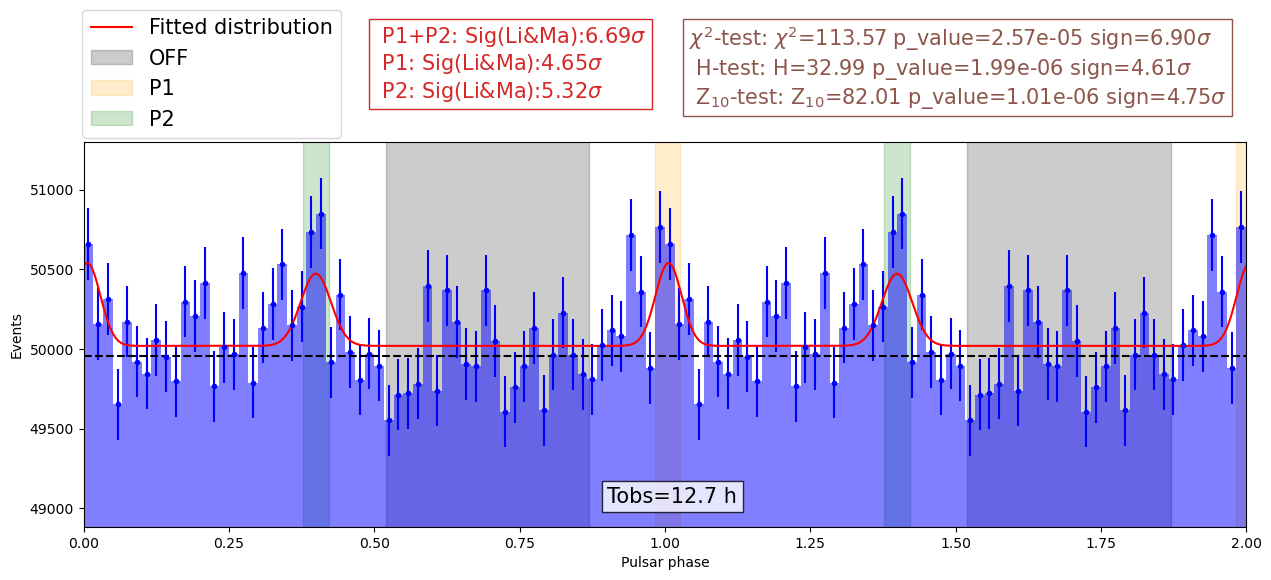

In [113]:
h.histogram.show_phaseogram(h,phase_limits=[0,2],fit=True,signal='both')

## 7.3. Performing and Unbinned Likelihood fit

We can also perform an Unbinned Likelihood fit that does not depend on the binning. Nonetheless, __the execution time increases notably with respect to the Binned fit__. Hence, this likelihood is recommended when the number of events is low and no clear model is visible in the lightcurve.

In [114]:
h.fitting.model='dgaussian'
h.fitting.init=[1,0.01,0.42,0.01,100,1,1]

In [115]:
h.fitting.fit_ULmodel(h)

/home/alvaro.mas/miniconda3/envs/lst-dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  """Entry point for launching an IPython kernel.
/home/alvaro.mas/miniconda3/envs/lst-dev/lib/python3.7/site-packages/numba/core/typed_passes.py:327: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "PulsarPhaseogram/models.py", line 8:
@nb.njit(**kwd)
def double_gaussian(x, mu, sigma,mu_2,sigma_2,A,B,C):
^

  state.func_ir.loc))


Again, we can show the resuls (mean value and error):

In [116]:
h.fitting.params

[1.000426259173262,
 0.010864984814306651,
 0.397987041004898,
 0.011160479793216528,
 129.9974569454067,
 0.06404746265520112,
 0.08431968659674217]

In [117]:
h.fitting.errors

[0.003912987003867503,
 0.004649589274837543,
 0.003121034891601673,
 0.0026203319713692637,
 0.7443182543392188,
 0.02053055345164717,
 0.018701443869023584]

We can also print the overall result:

In [118]:
h.fitting.show_result()

,Name,Value,Error
0,mu,1.000426,0.003913
1,sigma,0.010865,0.004650
2,mu_2,0.397987,0.003121
3,sigma_2,0.011160,0.002620
4,A,129.997457,0.744318
5,B,0.064047,0.020531
6,C,0.084320,0.018701


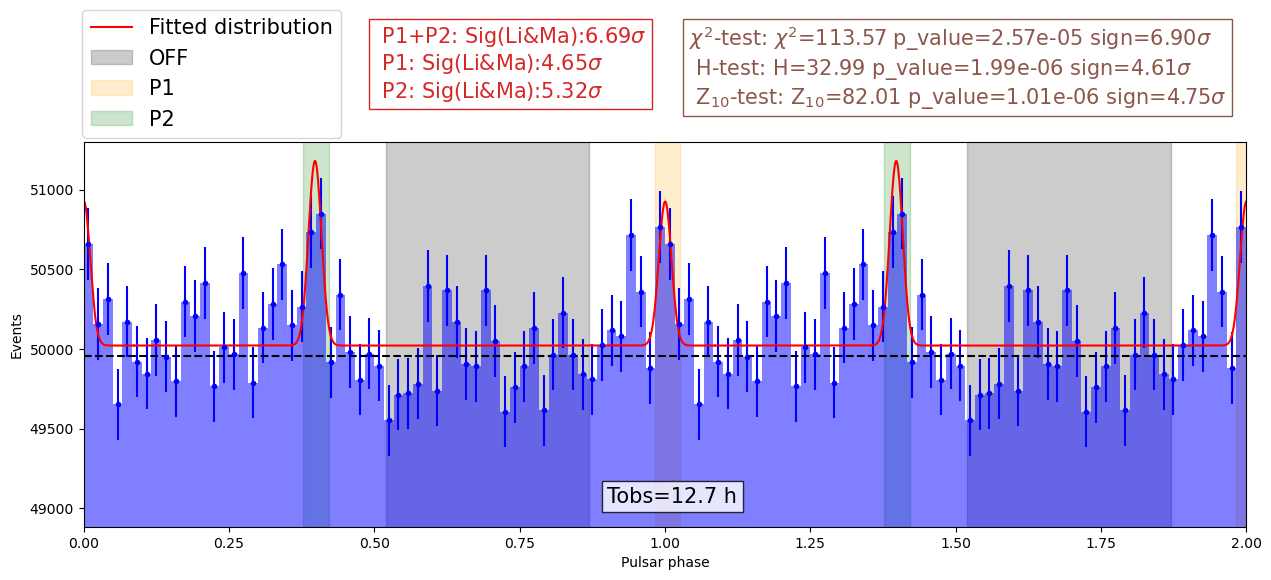

In [119]:
h.histogram.show_phaseogram(h,phase_limits=[0,2],fit=True,signal='both')

# 8.PulsarPhasesArray class

This class is a SuperClass of PulsarPhases. It allows to create an array of PulsarPhases objects based on a binning in energy. Therefore, we have to give the same inputs as for PulsarPhases but adding an extra parameter for the energy binning:


- The dataframe or lists of phases, energies and times (__dataframe__ or __pdata__,__penergies__,__ptimes__)


-  Energy edges of the binning (__energy_edges__)


- The phase interval of the two peaks (__peak_limits_1 and peak_limits_2__) and the phase interval of the background region in the lightcurve (__off_limits__)


- The number of bins used in the lightcurve (__nbins__)
        Default:50
    
    
- A boolean input called __binned__. If True, a binned fit is applied, otherwise an unbinned fit is used.
        Default:True
        
        
- Telescope name (optional): LST1 or Fermi-LAT (Default LST1)

In [3]:
h_array=PulsarPhasesArray(DL2_df,energy_edges=np.logspace(np.log10(0.07),np.log10(0.4), 5),nbins=40,peak_limits_1=[0.983,0.026],peak_limits_2=[0.377,0.422],off_limits=[0.52,0.87],binned=True,model='dgaussian')

/home/alvaro.mas/miniconda3/envs/lst-dev/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/alvaro.mas/miniconda3/envs/lst-dev/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/alvaro.mas/miniconda3/envs/lst-dev/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


First, we can show the energy binning parameters, and other general ones:

In [24]:
h_array.energy_edges

array([  50,  100,  500, 1000, 5000])

In [25]:
h_array.energy_centres

array([  75.,  300.,  750., 3000.])

In [26]:
print(h_array.energies)
print(h_array.phases)

[ 178.04679871 1350.0612793   214.36199951 ...  110.63629913  339.47653198
  429.93270874]
[-0.19360772  0.03298452  0.28056354 ... -0.25200049  0.33016034
 -0.1875827 ]


We can access to the information of each of the PulsarPhases objects:

In [5]:
h_low=h_array.Parray[0]

In [6]:
h_low.stats.resume_Pstats()

,Chi_square_test,Zn_test,H_test
Statistic,37.752487,22.309674,6.351897
p-value,0.526713,0.323946,0.079814
Number of $\sigma$,5.317258,0.456692,1.406323


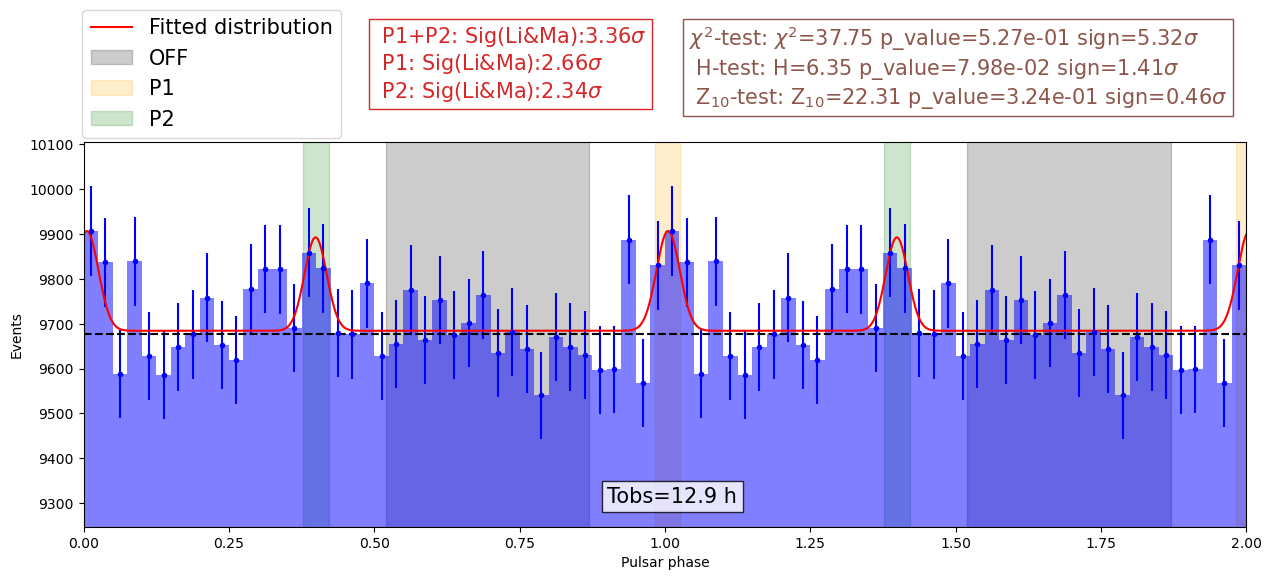

In [7]:
h_low.histogram.show_phaseogram(h_low,phase_limits=[0,2],fit=True,signal='both')

We can also show the result in each bin using the array of PulsarPhases objects:

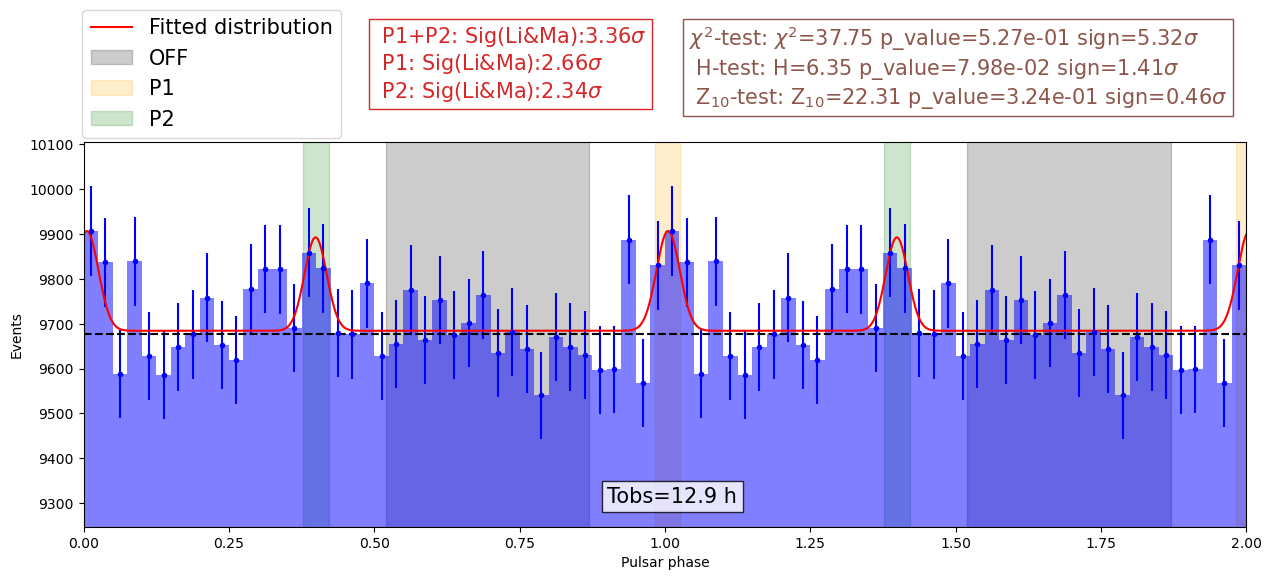

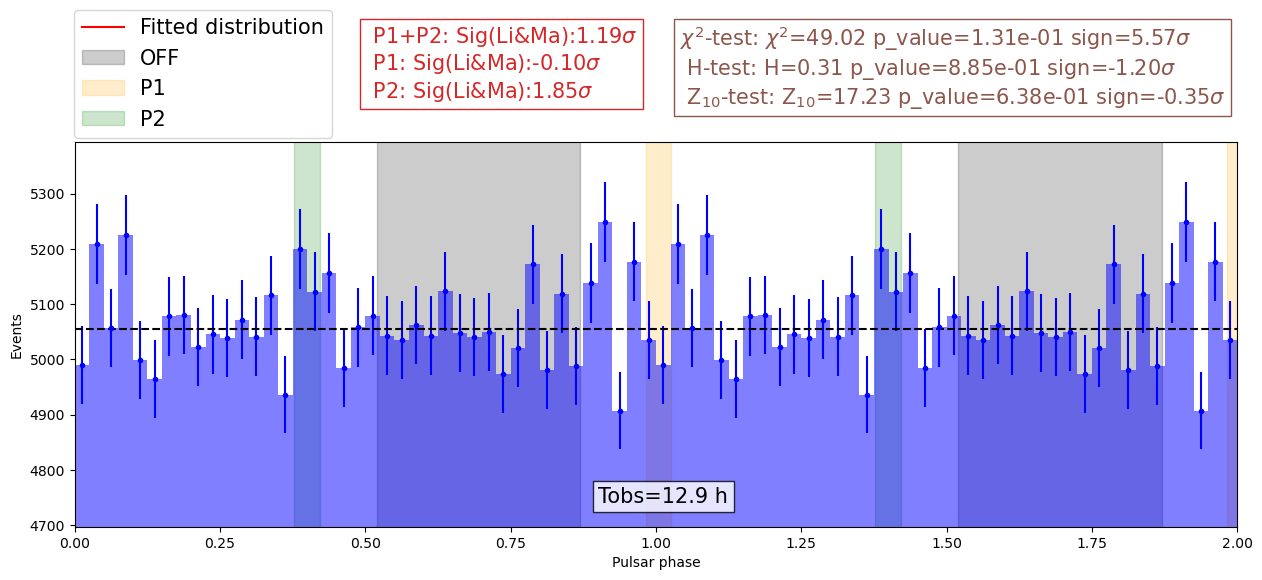

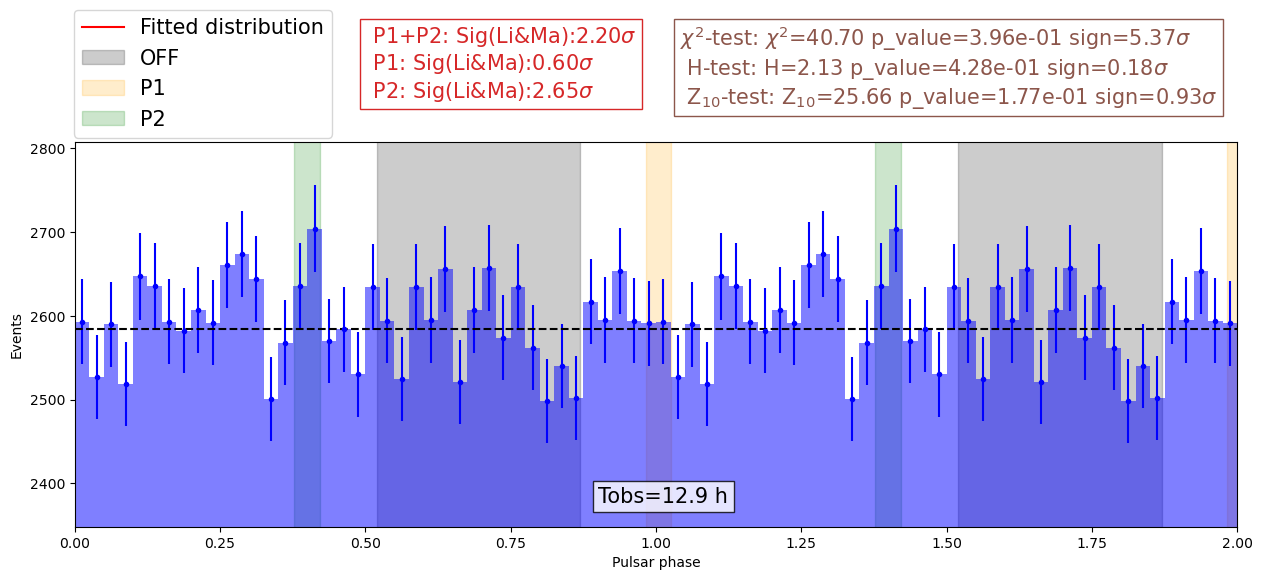

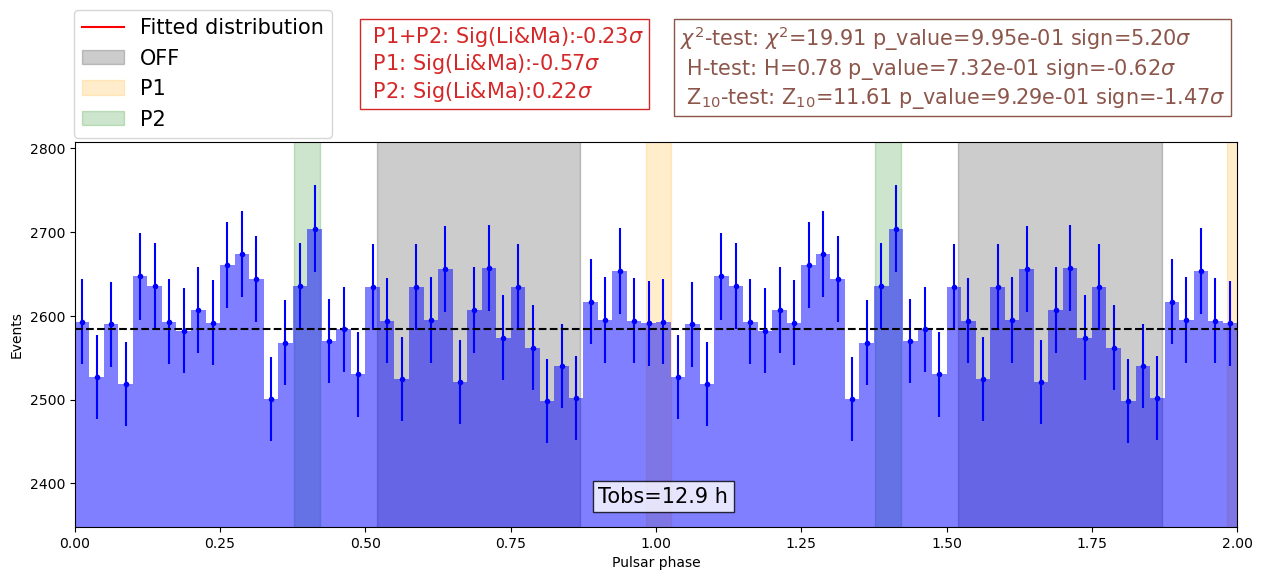

In [4]:
h_array.Parray[0].histogram.show_phaseogram(h_array.Parray[0],[0,2],fit=True)
h_array.Parray[1].histogram.show_phaseogram(h_array.Parray[1],[0,2],fit=True)
h_array.Parray[2].histogram.show_phaseogram(h_array.Parray[2],[0,2],fit=True)
h_array.Parray[2].histogram.show_phaseogram(h_array.Parray[3],[0,2],fit=True)

We can also represent the results as a function of the energy (for example, significance of the peaks vs energy):

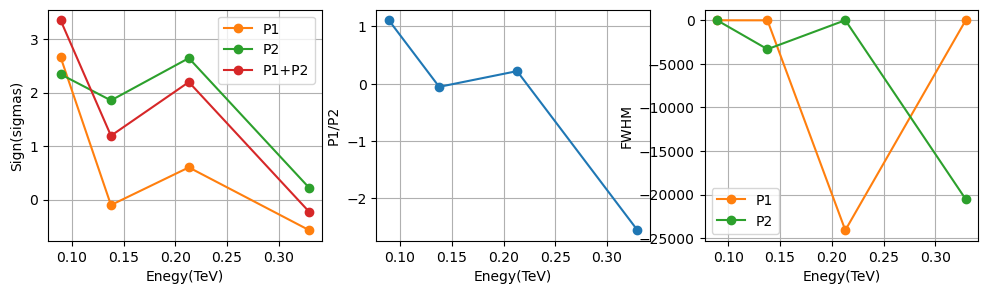

In [8]:
h_array.PeaksVsEnergy()